## COMS-4995 HW2 - Problem2

### va2361 (Vishal Anand), ss5348 (Somya Singhal)

### Python 3.6, Keras, CUDA-9.1, cuDNN-9.0, Tensorflow-1.4.0

In [1]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.preprocessing.text import text_to_word_sequence
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

import numpy as np, os, pickle, re, matplotlib.pyplot as plt, warnings
%matplotlib inline

/home/anand_vishal2994/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class LSTM_MT(object):
    def define_model(self, batch, n, latent_dim, num_samples, parallel_data):
        sources, sinks = [], []
        src_chars, tgt_chars = set(), set()
        tgt_chars.add('\t')
        tgt_chars.add('\n')

        with open(parallel_data, 'r', encoding='utf-8') as f:
            lines = f.read().split('\n')

        for line in lines[: min(num_samples, len(lines) - 1)]:
            source, sink = line.split('\t')
            sources.append(source)
            for char in source:
                src_chars.add(char)

            #Tab is the start character and newline is the end character for target language
            #This facilitates the beginning character generation from latent space and source (like language modelling PCFGs)
            sinks.append('\t' + sink + '\n')
            for char in sink:
                tgt_chars.add(char)

        src_chars, tgt_chars = sorted(list(src_chars)), sorted(list(tgt_chars))
        len_src_chars, len_tgt_chars = len(src_chars), len(tgt_chars)
        max_src_sentence_len, max_tgt_sentence_len = max([len(txt) for txt in sources]), max([len(txt) for txt in sinks])

        src_char_index = dict([(char, i) for i, char in enumerate(src_chars)])
        tgt_char_index = dict([(char, i) for i, char in enumerate(tgt_chars)])
        rev_input_char_index = dict((i, char) for char, i in src_char_index.items())
        rev_tgt_char_index = dict((i, char) for char, i in tgt_char_index.items())

        src_input = np.zeros((len(sources), max_src_sentence_len, len_src_chars), dtype='float64')
        tgt_input = np.zeros((len(sources), max_tgt_sentence_len, len_tgt_chars), dtype='float64')
        tgt_tgt_data = np.zeros((len(sources), max_tgt_sentence_len, len_tgt_chars), dtype='float64')

        for i, (source, sink) in enumerate(zip(sources, sinks)):
            for t, char in enumerate(source):
                src_input[i, t, src_char_index[char]] = 1.0
            for t, char in enumerate(sink):
                tgt_input[i, t, tgt_char_index[char]] = 1.0
                if t >= 1:
                    tgt_tgt_data[i, t - 1, tgt_char_index[char]] = 1.0

        src_inputs = Input(shape=(None, len_src_chars))
        encoder = LSTM(latent_dim, return_state=True)
        _, state_h, state_c = encoder(src_inputs)
        src_states = [state_h, state_c]
        tgt_inputs = Input(shape=(None, len_tgt_chars))
        tgt_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
        tgt_outputs, _, _ = tgt_lstm(tgt_inputs, initial_state=src_states)
        tgt_dense = Dense(len_tgt_chars, activation='softmax')
        tgt_outputs = tgt_dense(tgt_outputs)

        model = Model([src_inputs, tgt_inputs], tgt_outputs)
        model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

        indices = np.random.permutation(len(src_input))
        mask = int(0.9 * len(indices))
        training_idx, test_idx = indices[:mask], indices[mask:]

        src_input_train_val = src_input[training_idx]
        tgt_input_train_val = tgt_input[training_idx]
        tgt_tgt_data_train_val = tgt_tgt_data[training_idx]
        src_train_val = [sources[i] for i in training_idx]

        src_input_test = src_input[test_idx]
        tgt_input_test = tgt_input[test_idx]
        tgt_tgt_data_test = tgt_tgt_data[test_idx]
        sinks_test = [sinks[i] for i in test_idx]

        print(len(src_input_train_val), len(tgt_input_train_val), \
              len(tgt_tgt_data_train_val), len(src_train_val))
        print(len(src_input_test), len(tgt_input_test), \
              len(tgt_tgt_data_test), len(sinks_test))

        h = model.fit([src_input_train_val, tgt_input_train_val], \
                         tgt_tgt_data_train_val, batch_size=batch, \
                         epochs=n, validation_split=0.2)

        src_model = Model(src_inputs, src_states)
        tgt_state_input_h = Input(shape=(latent_dim,))
        tgt_state_input_c = Input(shape=(latent_dim,))
        tgt_states_inputs = [tgt_state_input_h, tgt_state_input_c]

        tgt_outputs, state_h, state_c = tgt_lstm(tgt_inputs, initial_state=tgt_states_inputs)
        tgt_model = Model([tgt_inputs] + tgt_states_inputs, [tgt_dense(tgt_outputs)] + [state_h, state_c])

        return h, model, src_input, sinks, src_model, \
            len_tgt_chars, tgt_char_index, tgt_model, \
            rev_tgt_char_index, max_tgt_sentence_len, test_idx

    def decode_sequence(self, input_seq, src_model, len_tgt_chars, \
                        tgt_char_index, tgt_model, rev_tgt_char_index, \
                        max_tgt_sentence_len):
        decoded_status = 0
        predict_tgt = ""
        states_value = src_model.predict(input_seq)
        tgt_seq = np.zeros((1, 1, len_tgt_chars))
        tgt_seq[0, 0, tgt_char_index['\t']] = 1.0

        while decoded_status != 1:
            out_tokens, h, c = tgt_model.predict([tgt_seq] + states_value)
            arg_max_char = np.argmax(out_tokens[0, -1, :])
            predict_tgt += rev_tgt_char_index[arg_max_char]

            if (predict_tgt[-1] == '\n' or len(predict_tgt) > max_tgt_sentence_len):
                decoded_status = 1
            tgt_seq = np.zeros((1, 1, len_tgt_chars))
            tgt_seq[0, 0, arg_max_char] = 1.0
            states_value = [h, c]

        return predict_tgt

In [3]:
batch_size = 40
epochs = 30
latent_dim = 250
num_samples = 10000
data_path = 'data/deu-eng/deu.txt'

lstm_mt = LSTM_MT()
fit_history, model, encoder_input_data, target_texts, encoder_model, \
    num_decoder_tokens, target_token_index, decoder_model, \
    reverse_target_char_index, max_decoder_seq_length, test_idx = \
        lstm_mt.define_model(batch_size, epochs, latent_dim, num_samples, data_path)
    
loss = fit_history.history['loss']
val_loss = fit_history.history['val_loss']

encoder_input_data_test = encoder_input_data[test_idx]
target_texts_test = [target_texts[i] for i in test_idx]

9000 9000 9000 9000
1000 1000 1000 1000
Train on 7200 samples, validate on 1800 samples
Epoch 1/30
7200/7200 [==============================] - 22s 3ms/step - loss: 0.7258 - val_loss: 0.5985
Epoch 2/30
7200/7200 [==============================] - 20s 3ms/step - loss: 0.5358 - val_loss: 0.4861
Epoch 3/30
7200/7200 [==============================] - 21s 3ms/step - loss: 0.4610 - val_loss: 0.4439
Epoch 4/30
7200/7200 [==============================] - 21s 3ms/step - loss: 0.4236 - val_loss: 0.4134
Epoch 5/30
7200/7200 [==============================] - 21s 3ms/step - loss: 0.3962 - val_loss: 0.3957
Epoch 6/30
7200/7200 [==============================] - 21s 3ms/step - loss: 0.3748 - val_loss: 0.3746
Epoch 7/30
7200/7200 [==============================] - 21s 3ms/step - loss: 0.3564 - val_loss: 0.3614
Epoch 8/30
7200/7200 [==============================] - 21s 3ms/step - loss: 0.3407 - val_loss: 0.3491
Epoch 9/30
7200/7200 [==============================] - 20s 3ms/step - loss: 0.3262 - va

In [24]:
bleu_scores = []
converted_text = []

f_translate = open('translation.txt', 'w')
actual_text_non_split = []
predicted_output_non_split = []

actual_text_split = []
predicted_output_split = []

def mean_list(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

for i, seq_index in tqdm(enumerate(test_idx)):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = lstm_mt.decode_sequence(input_seq, encoder_model, 
                                       num_decoder_tokens, target_token_index, 
                                       decoder_model, reverse_target_char_index, max_decoder_seq_length)
    text1 = ' '.join(decoded_sentence[:-1].split())
    text2 = target_texts[seq_index][1:][:-1]
    
    actual_text_split.append([text_to_word_sequence(text2)])
    predicted_output_split.append(text_to_word_sequence(text1))
    
#     actual_text_non_split.append([text2])
#     predicted_output_non_split.append(text1)
    
    bleu_score_val = sentence_bleu([text_to_word_sequence(text1)], text_to_word_sequence(text2))
    #f_translate.write("Prediction: " + text1 + "\tActual: " + text2 + "\tBLEU: " + str(round(bleu_score_val, 2)) + "\n")
    f_translate.write("Sentence_Level_BLEU: " + str(round(bleu_score_val, 5)) + "\tPrediction: " + text1 + "\tActual:" + text2 + "\n")
    #f_translate.write("Prediction: " + text1 + "\tActual:" + text2 + "\n")
    bleu_scores.append(bleu_score_val)
    converted_text.append((text1, text2, bleu_score_val))

0it [00:00, ?it/s]/home/anand_vishal2994/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/anand_vishal2994/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
7it [00:00, 26.53it/s]/home/anand_vishal2994/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
1000it [00:41, 24.09it/s]


In [28]:
#bleu_score_val = sentence_bleu([text_to_word_sequence(mother_lode)], text_to_word_sequence(predicted_output))
#print(mother_lode)
from nltk.translate.bleu_score import corpus_bleu

BLEU_val = mean_list(bleu_scores)
print("Mean Sentence_Level_BLEU_Score:", BLEU_val)

corpus_bleu_score_val_split = corpus_bleu(actual_text_split, predicted_output)
#corpus_bleu_score_val_non_split = corpus_bleu(actual_text_non_split, predicted_output)
print("Corpus_bleu_score (Split_sentences):", corpus_bleu_score_val_split)
#print("Corpus_bleu_score (Non-split_sentences):", corpus_bleu_score_val_non_split)

Mean Sentence_Level_BLEU_Score: 0.4976887629613061
Corpus_bleu_score (Split_sentences): 0.05149695222519065


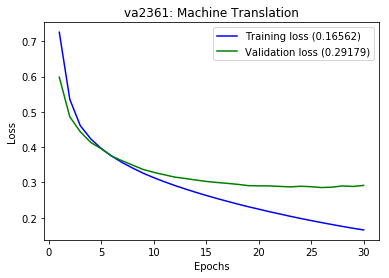

BLEU		Pred			Actual
1.0		Tom wird gehen.		Tom wird gehen.
1.0		Er kann nicht schwimmen.		Er kann nicht schwimmen.
1.0		Tom sah gut aus.		Tom sah gut aus.
1.0		Tom hat eine Erkältung.		Tom hat eine Erkältung.
0.9306		Ist das nicht Tom?		Ist Tom nicht schwer?
0.9036		Ist das deins?		Ist es das?
0.9036		Wir sollten gehen.		Wir müssen gehen.
0.8409		Tom lügt.		Tom schläft.
0.8409		Tom fehlt.		Tom schläft.
0.8409		Es wird nicht schaden.		Es war nicht schlecht.
0.8409		Lass Tom fertig machen.		Lass mich das machen.
0.8409		Was wird Tom gewinnen?		Was für ein Tom?
0.8409		Wie schlau!		Wie seltsam!
0.8409		Tom hustet.		Tom schläft.
0.8409		Tom fällt.		Tom schläft.
0.8409		Tom hat nicht Recht.		Tom ist nicht gemein.
0.8409		Der Soldat ist gerannt.		Der Mann ist beschäftigt.
0.8409		So ist das Leben!		Das ist ein Buch.
0.8409		Tom stirbt.		Tom schläft.
0.8409		Ist dies ein Fluß?		Ist das ein Freund?
0.8409		Wer fastet?		Wer schrimm?
0.8409		Paddel weiter!		Alle weiter.
0.8409		Tom kichert.		Tom 

In [5]:
epochs = range(1,len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss (' + str(str(format(loss[-1],'.5f'))+')'))
plt.plot(epochs, val_loss, 'g', label='Validation loss (' + str(str(format(val_loss[-1],'.5f'))+')'))
plt.title('va2361: Machine Translation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("va2361_DL.PNG")
plt.show()

bleu_sorted_analysis = bleu_scores
idx = sorted(range(len(bleu_sorted_analysis)), key=bleu_sorted_analysis.__getitem__)
idx.reverse()

print("Sentence_Level_BLEU\t\tPred\t\t\tActual")
for index in idx[:30]:
    text1, text2, score = converted_text[index]
    #print("Pred: " + text1 + "\t\t: " + text2 + "\tBLEU: " + str(round(bleu_scores[index], 2)))
    print(str(round(bleu_scores[index], 5)) + "\t\t" + text2 + "\t\t" + text1)
    #print(str(round(bleu_scores[index], 8)) + " & " + text2 + " & " + text1 + "\\\\")


In [6]:
print("Model")
model.summary()

print("\n\nEncoder model")
encoder_model.summary()

print("\n\nDecoder model")
decoder_model.summary()

Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 69)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 85)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 250), (None, 320000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 250),  336000      input_2[0][0]                    
                                                                 lstm_1[0][1]                     
    